# Load Dependencies

In [2]:
import pandas as pd
import numpy as np
import glob
import torch
import torch.optim as optim
from torch.utils.data import Dataset
from torch.nn import Parameter
from rdkit import Chem
from tensorflow.keras.callbacks import ModelCheckpoint
from script_baseline.Baseline_MG import get_mg_nodes_feat,Get_Baseline_MG_feat
from script_baseline.GCN import GCN2
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt

# Load Data

In [5]:
data_file = '../Data/data2/data2.csv'
mol_dir = '../Data/data2/xtb_sdf/'
tmp_df = pd.read_csv(data_file)
labels_ori = np.array(tmp_df['Output'].to_list())

In [6]:
def sort_func(x): return eval(x.split('/')[-1].split('.')[0].split('_')[-1])
cat_files = sorted(glob.glob('../data2/data2_sdf_files/cat_*.sdf'),key=sort_func)
imine_files = sorted(glob.glob('../data2/data2_sdf_files/imine_*.sdf'),key=sort_func)
thiol_files = sorted(glob.glob('../data2/data2_sdf_files/thiol_*.sdf'),key=sort_func)

with open(mol_dir+'smiles_file_dict.csv','r') as fr:
    lines = fr.readlines()
smiles_name_dict = {tmp_line.strip().split(',')[0]:tmp_line.strip().split(',')[1] for tmp_line in lines}

# Generate Baseline MG

In [7]:
imine_Graph_name_dict=Get_Baseline_MG_feat(imine_files)

../data2/data2_sdf_files/imine_0.sdf
../data2/data2_sdf_files/imine_1.sdf
../data2/data2_sdf_files/imine_2.sdf
../data2/data2_sdf_files/imine_3.sdf
../data2/data2_sdf_files/imine_4.sdf


In [8]:
cat_Graph_name_dict=Get_Baseline_MG_feat(cat_files)

../data2/data2_sdf_files/cat_0.sdf
../data2/data2_sdf_files/cat_1.sdf
../data2/data2_sdf_files/cat_2.sdf
../data2/data2_sdf_files/cat_3.sdf
../data2/data2_sdf_files/cat_4.sdf
../data2/data2_sdf_files/cat_5.sdf
../data2/data2_sdf_files/cat_6.sdf
../data2/data2_sdf_files/cat_7.sdf
../data2/data2_sdf_files/cat_8.sdf
../data2/data2_sdf_files/cat_9.sdf
../data2/data2_sdf_files/cat_10.sdf
../data2/data2_sdf_files/cat_11.sdf
../data2/data2_sdf_files/cat_12.sdf
../data2/data2_sdf_files/cat_13.sdf
../data2/data2_sdf_files/cat_14.sdf
../data2/data2_sdf_files/cat_15.sdf
../data2/data2_sdf_files/cat_16.sdf
../data2/data2_sdf_files/cat_17.sdf
../data2/data2_sdf_files/cat_18.sdf
../data2/data2_sdf_files/cat_19.sdf
../data2/data2_sdf_files/cat_20.sdf
../data2/data2_sdf_files/cat_21.sdf
../data2/data2_sdf_files/cat_22.sdf
../data2/data2_sdf_files/cat_23.sdf
../data2/data2_sdf_files/cat_24.sdf
../data2/data2_sdf_files/cat_25.sdf
../data2/data2_sdf_files/cat_26.sdf
../data2/data2_sdf_files/cat_27.sdf
..

In [9]:
thiol_Graph_name_dict=Get_Baseline_MG_feat(thiol_files)

../data2/data2_sdf_files/thiol_0.sdf
../data2/data2_sdf_files/thiol_1.sdf
../data2/data2_sdf_files/thiol_2.sdf
../data2/data2_sdf_files/thiol_3.sdf
../data2/data2_sdf_files/thiol_4.sdf


# Load Graph Dataset

In [10]:
class Graph_DataSet(Dataset):

    def __init__(self, root,csv_dir,sdf_dir, train=True, transform = None, target_transform=None):
        super(Graph_DataSet, self).__init__()
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

        if self.train :
            file_annotation = root + csv_dir
            sdf_folder = root +sdf_dir
        else:
            file_annotation = root +csv_dir
            sdf_folder = root + sdf_dir
        df = pd.read_csv(file_annotation)
        target = np.array(df['Output'].to_list())
        self.target_min = target.min()
        self.target_range = target.max() - target.min()
        
        target_std = (target - target.min())/(target.max()-target.min())
        
        cat_smi = df['Catalyst'].to_list()
        imine_smi = df['Imine'].to_list()
        thiol_smi = df['Thiol'].to_list()
        
        
        cat_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in cat_smi]
        imine_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in imine_smi]
        thiol_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in thiol_smi]
        
        self.cat_file_names = cat_file_names
        self.imine_file_names = imine_file_names
        self.thiol_file_names = thiol_file_names
        
        self.target_std = target_std
        self.sdf_folder = sdf_folder
            
    def __getitem__(self, index):
        cat_name = self.cat_file_names[index]
        imine_name = self.imine_file_names[index]
        thiol_name = self.thiol_file_names[index]
        label = self.target_std[index]

        graph_1 = cat_Graph_name_dict[cat_name]
        graph_2 = imine_Graph_name_dict[imine_name]
        graph_3 = thiol_Graph_name_dict[thiol_name]
        
        return [graph_1,graph_1.ndata['feat'],graph_2,graph_2.ndata['feat'],graph_3,graph_3.ndata['feat']], label

    def __len__(self):
        return len(self.target_std)

# Train Model

In [11]:
loss = 'mse'
batch_size = 128
shuffle = np.array(list(range(1075)))
np.random.shuffle(shuffle)
train_index = shuffle[:600]
val_index = shuffle[600:]
dataset = Graph_DataSet('../Data/data2',csv_dir='/data2.csv' , sdf_dir='/xtb_sdf/')
train_data=[]
for i in train_index:
    tem_data=dataset[i]
    train_data.append(tem_data)
    
val_data=[]
for i in val_index:
    tem_data=dataset[i]
    val_data.append(tem_data)     

In [12]:
#opt: conv 3; multi_graph_opt='max'; output_opt='mean'
model_opt = GCN2(15,256,1,multi_graph_opt='max',output_opt='mean',layer=3)
optimizer = optim.Adam(model_opt.parameters())
loss_func = torch.nn.L1Loss()

checkpoint=ModelCheckpoint("../Dataset/run_data/model_cusgraph.hdf5",
                               verbose=0,monitor='loss',
                               save_best_only=True,mode='min')
for epoch in range(50):
    get_output=[]
    all_loss = []
    model_opt.train()
    for i, data in enumerate(train_data):
        inputs, labels = data
        outputs = model_opt(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],)
        get_output.append(outputs)

        labels = torch.tensor(labels) 
        
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        all_loss.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
    print('Train MSE',np.mean(all_loss))
    model_opt.eval()
    test_get_output=[]
    test_all_labels = []
    all_loss = []
    for data in val_data:
        inputs, labels = data
        outputs = model_opt(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],)
        test_get_output.append(outputs)
        labels = torch.tensor(labels) 
        test_all_labels.append(labels)
        loss = loss_func(outputs, labels)
        all_loss.append(loss.detach().numpy())
    print('Test MSE',np.mean(all_loss))   

Train MSE 0.16695531634697594
Test MSE 0.1595788442816729
Train MSE 0.1663821708567845
Test MSE 0.1573873730652986
Train MSE 0.16171372908211673
Test MSE 0.15787124205183495
Train MSE 0.1598281395784673
Test MSE 0.15828347234349055
Train MSE 0.15858840529040308
Test MSE 0.1560101679026092
Train MSE 0.15777933023790536
Test MSE 0.1545014740274719
Train MSE 0.15716614980985175
Test MSE 0.1541650032208849
Train MSE 0.15712030594709164
Test MSE 0.15455658251729765
Train MSE 0.15556481799443656
Test MSE 0.1542112721466586
Train MSE 0.15415711765683962
Test MSE 0.15338729602590093
Train MSE 0.15374283581847578
Test MSE 0.15206630218804365
Train MSE 0.15308617168761235
Test MSE 0.15095863358791445
Train MSE 0.15139941283405842
Test MSE 0.15091075630917714
Train MSE 0.14919578741520814
Test MSE 0.1488877448108143
Train MSE 0.14809992851330786
Test MSE 0.14809338222495416
Train MSE 0.14576988920588857
Test MSE 0.14624466905456995
Train MSE 0.1441540528883211
Test MSE 0.14328270011532368
Train M

In [13]:
test_all_labels_=[]
for i in test_all_labels:
    test_all_labels_.append(i.tolist())
    
test_get_output_=[]
for i in test_get_output:
    test_get_output_.append(i.tolist())
y_val=np.array(test_all_labels_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()
y_pred=np.array(test_get_output_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()

# Results

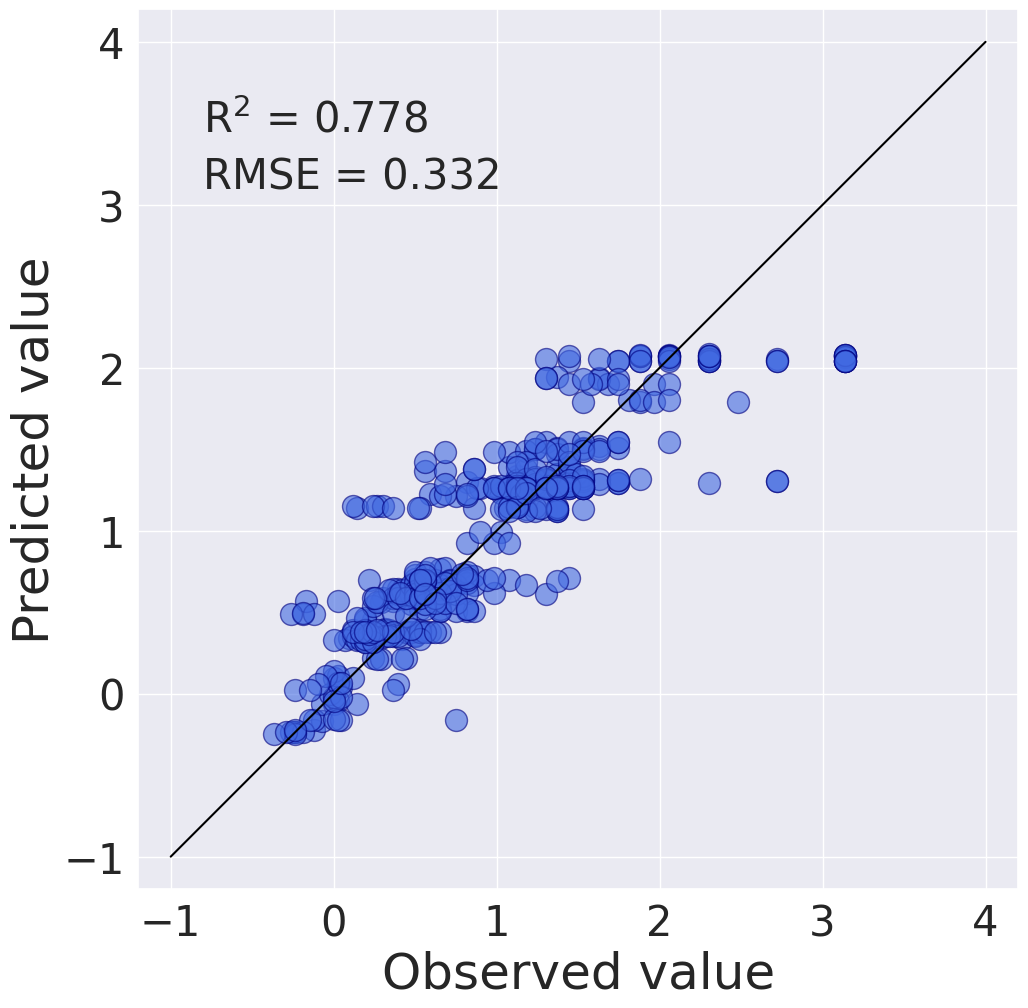

In [14]:
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',   
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.plot([-1,4],[-1,4],c='black')

plt.xlim(-1.2,4.2)
plt.ylim(-1.2,4.2)
x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed value",fontsize=36)
plt.ylabel("Predicted value",fontsize=36)
plt.tick_params(labelsize=30)
plt.text(-0.8,3.1,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(-0.8,3.45,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

In [15]:
np.save('../result/data2_Baseline_MG_GCN_y_val.npy',y_val)
np.save('../result/data2_Baseline_MG_GCN_y_pred.npy',y_pred)